# Imports


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# import os
# from google.colab import drive
# from gensim.models import Word2Vec
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from collections import Counter
import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from sentence_transformers import SentenceTransformer
import gensim.downloader as api
import fasttext.util
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to /Users/User/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/User/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/User/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/User/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/Users/User/Downloads/bt4222-group-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/User/Downloads/bt4222-group-project/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user

# Mounting data and Combining train, test and validation datasets, for splitting later on


In [2]:
# Uncomment to mount Google Drive
# drive.mount('/content/drive')

# %cd /content/drive/My Drive/LiarLiarPantsOnFire/bt4222-group-project
# print(os.listdir())

## Read csv file from a directory into pandas DataFrame

In [3]:
# Modify directory if needed
train = pd.read_csv("train.tsv", delimiter = '\t')
valid = pd.read_csv("valid.tsv", delimiter = '\t')
test = pd.read_csv("test.tsv", delimiter = '\t')

In [4]:
# adding column names
column_names = [
    'id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts', 'context'
]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

In [5]:
train.head()

id        label                                          statement  \
0  10540.json    half-true  When did the decline of coal start? It started...   
1    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
2   1123.json        false  Health care reform legislation is likely to ma...   
3   9028.json    half-true  The economic turnaround started at the end of ...   
4  12465.json         true  The Chicago Bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   charlie-crist   
4                           education       robin-vos   

            speaker_job_title state_info party_affiliation  \
0              State delegate   Virginia          democrat   
1                   President   Illinois          democrat   
2                         NaN        NaN              none   
3                         NaN    Florida          democrat   
4  Wisconsin Assembly speaker  Wisconsin        republican   

   barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
0                 0.0           0.0               1.0                 1.0   
1                70.0          71.0             160.0               163.0   
2                 7.0          19.0               3.0                 5.0   
3                15.0           9.0              20.0                19.0   
4                 0.0           3.0               2.0                 5.0   

   pants_on_fire_counts                    context  
0                   0.0            a floor speech.  
1                   9.0                     Denver  
2                  44.0             a news release  
3                   2.0        an interview on CNN  
4                   1.0  a an online opinion-piece

In [6]:
valid.head()

id       label                                          statement  \
0   238.json  pants-fire  When Obama was sworn into office, he DID NOT u...   
1  7891.json       false  Says Having organizations parading as being so...   
2  8169.json   half-true     Says nearly half of Oregons children are poor.   
3   929.json   half-true  On attacks by Republicans that various program...   
4  9416.json       false  Says when armed civilians stop mass shootings ...   

                            subject          speaker  \
0  obama-birth-certificate,religion      chain-email   
1   campaign-finance,congress,taxes  earl-blumenauer   
2                           poverty  jim-francesconi   
3                  economy,stimulus     barack-obama   
4                              guns       jim-rubens   

                               speaker_job_title     state_info  \
0                                            NaN            NaN   
1                            U.S. representative         Oregon   
2  Member of the State Board of Higher Education         Oregon   
3                                      President       Illinois   
4                           Small business owner  New Hampshire   

  party_affiliation  barely_true_counts  false_counts  half_true_counts  \
0              none                  11            43                 8   
1          democrat                   0             1                 1   
2              none                   0             1                 1   
3          democrat                  70            71               160   
4        republican                   1             1                 0   

   mostly_true_counts  pants_on_fire_counts  \
0                   5                   105   
1                   1                     0   
2                   1                     0   
3                 163                     9   
4                   1                     0   

                                       context  
0                                          NaN  
1                a U.S. Ways and Means hearing  
2                           an opinion article  
3                      interview with CBS News  
4  in an interview at gun shop in Hudson, N.H.

In [7]:
test.head()

id       label                                          statement  \
0  11685.json       false  Wisconsin is on pace to double the number of l...   
1  11096.json       false  Says John McCain has done nothing to help the ...   
2   5209.json   half-true  Suzanne Bonamici supports a plan that will cut...   
3   9524.json  pants-fire  When asked by a reporter whether hes at the ce...   
4   5962.json        true  Over the past five years the federal governmen...   

                                             subject  \
0                                               jobs   
1                    military,veterans,voting-record   
2  medicare,message-machine-2012,campaign-adverti...   
3  campaign-finance,legal-issues,campaign-adverti...   
4                 federal-budget,pensions,retirement   

                            speaker     speaker_job_title    state_info  \
0                 katrina-shankland  State representative     Wisconsin   
1                      donald-trump       President-Elect      New York   
2                     rob-cornilles            consultant        Oregon   
3  state-democratic-party-wisconsin                   NaN     Wisconsin   
4                   brendan-doherty                   NaN  Rhode Island   

  party_affiliation  barely_true_counts  false_counts  half_true_counts  \
0          democrat                   2             1                 0   
1        republican                  63           114                51   
2        republican                   1             1                 3   
3          democrat                   5             7                 2   
4        republican                   1             2                 1   

   mostly_true_counts  pants_on_fire_counts                       context  
0                   0                     0             a news conference  
1                  37                    61  comments on ABC's This Week.  
2                   1                     1                  a radio show  
3                   2                     7                   a web video  
4                   1                     0            a campaign website

In [8]:
# combining all data frames
df = pd.concat([train, valid, test], axis=0).reset_index(drop=True)

df.head()

id        label                                          statement  \
0  10540.json    half-true  When did the decline of coal start? It started...   
1    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
2   1123.json        false  Health care reform legislation is likely to ma...   
3   9028.json    half-true  The economic turnaround started at the end of ...   
4  12465.json         true  The Chicago Bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   charlie-crist   
4                           education       robin-vos   

            speaker_job_title state_info party_affiliation  \
0              State delegate   Virginia          democrat   
1                   President   Illinois          democrat   
2                         NaN        NaN              none   
3                         NaN    Florida          democrat   
4  Wisconsin Assembly speaker  Wisconsin        republican   

   barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
0                 0.0           0.0               1.0                 1.0   
1                70.0          71.0             160.0               163.0   
2                 7.0          19.0               3.0                 5.0   
3                15.0           9.0              20.0                19.0   
4                 0.0           3.0               2.0                 5.0   

   pants_on_fire_counts                    context  
0                   0.0            a floor speech.  
1                   9.0                     Denver  
2                  44.0             a news release  
3                   2.0        an interview on CNN  
4                   1.0  a an online opinion-piece

# Data Cleaning and EDA



## Remove duplicates

In [9]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

## Check data types and distribution of numerical values

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12788 entries, 0 to 12787
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12788 non-null  object 
 1   label                 12788 non-null  object 
 2   statement             12788 non-null  object 
 3   subject               12786 non-null  object 
 4   speaker               12786 non-null  object 
 5   speaker_job_title     9221 non-null   object 
 6   state_info            10039 non-null  object 
 7   party_affiliation     12786 non-null  object 
 8   barely_true_counts    12786 non-null  float64
 9   false_counts          12786 non-null  float64
 10  half_true_counts      12786 non-null  float64
 11  mostly_true_counts    12786 non-null  float64
 12  pants_on_fire_counts  12786 non-null  float64
 13  context               12657 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.4+ MB
None


In [11]:
print(df.describe())

       barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
count        12786.000000  12786.000000      12786.000000        12786.000000   
mean            11.584233     13.359768         17.186454           16.499922   
std             18.979057     24.141933         35.850604           36.168885   
min              0.000000      0.000000          0.000000            0.000000   
25%              0.000000      0.000000          0.000000            0.000000   
50%              2.000000      2.000000          3.000000            3.000000   
75%             12.000000     15.000000         13.000000           12.000000   
max             70.000000    114.000000        160.000000          163.000000   

       pants_on_fire_counts  
count          12786.000000  
mean               6.251447  
std               16.182153  
min                0.000000  
25%                0.000000  
50%                1.000000  
75%                5.000000  
max              105.000000  


## Check for missing values
- drop rows with small number of null
- since speaker_job_title and state_info and context has a larger number of null values, but we still want to use them in our analysis, we input null values with 'unknown'


In [12]:
print(df.isnull().sum())

id                         0
label                      0
statement                  0
subject                    2
speaker                    2
speaker_job_title       3567
state_info              2749
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
dtype: int64


In [13]:
# Dropping rows with small number of nulls
df = df.dropna(subset=["subject", "speaker", "party_affiliation",
                       "barely_true_counts", "false_counts", "half_true_counts",
                       "mostly_true_counts", "pants_on_fire_counts"])

# Imputing missing values for speaker_jobs state to "Unknown"
df.loc[:, "speaker_job_title"] = df["speaker_job_title"].fillna("unknown")
df.loc[:, "state_info"] = df["state_info"].fillna("unknown")
df.loc[:, "context"] = df["context"].fillna("unknown")

In [14]:
print(df.isnull().sum())
print(df.info())

id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12786 entries, 0 to 12787
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12786 non-null  object 
 1   label                 12786 non-null  object 
 2   statement             12786 non-null  object 
 3   subject               12786 non-null  object 
 4   speaker               12786 non-null  object 
 5   speaker_job_title     12786 non-null  object 
 6   state_info            12786 non-null  object 
 7   party_affiliation     12786 non-null  object 
 8  

## Examining Unique Values in Categorical Features
- to understand how many unique values in each categorical column

In [15]:
categorical_columns = ['label', 'subject', 'speaker', 'speaker_job_title', 'state_info', 'party_affiliation', 'context']
categorical_uniques_sum = {col: df[col].nunique() for col in categorical_columns}
categorical_uniques_sum

{'label': 6,
 'subject': 4534,
 'speaker': 3308,
 'speaker_job_title': 1356,
 'state_info': 86,
 'party_affiliation': 24,
 'context': 5141}

In [16]:
categorical_uniques = {col: df[col].unique() for col in categorical_columns}
categorical_uniques

{'label': array(['half-true', 'mostly-true', 'false', 'true', 'barely-true',
        'pants-fire'], dtype=object),
 'subject': array(['energy,history,job-accomplishments', 'foreign-policy',
        'health-care', ..., 'animals,candidates-biography',
        'bipartisanship,congress,foreign-policy,history',
        'environment,government-efficiency'], dtype=object),
 'speaker': array(['scott-surovell', 'barack-obama', 'blog-posting', ...,
        'hugh-fitzsimons', 'menendez-facts', 'mackubin-thomas-owens'],
       dtype=object),
 'speaker_job_title': array(['State delegate', 'President', 'unknown', ...,
        'U.S. Supreme Court Justice', 'Rancher',
        'senior fellow, Foreign Policy Research Institute'], dtype=object),
 'state_info': array(['Virginia', 'Illinois', 'unknown', 'Florida', 'Wisconsin', 'Texas',
        'New Jersey', 'Vermont', 'Massachusetts', 'Maryland',
        'Washington, D.C. ', 'Oregon', 'New York', 'Washington, D.C.',
        'California', 'Missouri', 'Rhode

## Normalising string columns

### through lowering of cases and removing leading and lagging spaces


In [17]:
def clean_text(text):
    if isinstance(text, str):
        return text.lower().strip()
    return text

In [18]:
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).applymap(clean_text)
df.head()

id        label                                          statement  \
0  10540.json    half-true  when did the decline of coal start? it started...   
1    324.json  mostly-true  hillary clinton agrees with john mccain "by vo...   
2   1123.json        false  health care reform legislation is likely to ma...   
3   9028.json    half-true  the economic turnaround started at the end of ...   
4  12465.json         true  the chicago bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   charlie-crist   
4                           education       robin-vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown              none   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
0                 0.0           0.0               1.0                 1.0   
1                70.0          71.0             160.0               163.0   
2                 7.0          19.0               3.0                 5.0   
3                15.0           9.0              20.0                19.0   
4                 0.0           3.0               2.0                 5.0   

   pants_on_fire_counts                    context  
0                   0.0            a floor speech.  
1                   9.0                     denver  
2                  44.0             a news release  
3                   2.0        an interview on cnn  
4                   1.0  a an online opinion-piece

## Removal of punctuation

### For text columns other than 'statement' and 'subject', we remove punctuation as it is not useful and may cause duplicates

### Since there are subjects with puncutation inside e.g. 'foreign-policy', we keep puncuation for subjects

### Since punctuation may be useful in identifying bias and conveys meaning in 'statement', we keep it

In [19]:
def remove_punctuation(text):
    if isinstance(text, str):
      return text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    return text

In [20]:
# Apply to specific columns
cols_to_clean = ['speaker', 'speaker_job_title', 'state_info', 'party_affiliation', 'context']
df[cols_to_clean] = df[cols_to_clean].applymap(remove_punctuation)
df.head()

id        label                                          statement  \
0  10540.json    half-true  when did the decline of coal start? it started...   
1    324.json  mostly-true  hillary clinton agrees with john mccain "by vo...   
2   1123.json        false  health care reform legislation is likely to ma...   
3   9028.json    half-true  the economic turnaround started at the end of ...   
4  12465.json         true  the chicago bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown              none   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
0                 0.0           0.0               1.0                 1.0   
1                70.0          71.0             160.0               163.0   
2                 7.0          19.0               3.0                 5.0   
3                15.0           9.0              20.0                19.0   
4                 0.0           3.0               2.0                 5.0   

   pants_on_fire_counts                    context  
0                   0.0            a floor speech   
1                   9.0                     denver  
2                  44.0             a news release  
3                   2.0        an interview on cnn  
4                   1.0  a an online opinion piece

## Processing for 'statement' column

### lowercasing and removal of spaces were already conducted

###  here, we process the statement through: tokenization, removal of stopwords, lemmatization

In [21]:
def process_text(text):
    # Tokenization (by breaking the text into words)
    tokens = word_tokenize(text)

    # Filter Alphabetic Tokens
    alphabetic_tokens = [word for word in tokens if re.match('^[a-zA-Z]+$', word)]

    # Remove Stopwords and Negation Words
    stop_words = set(stopwords.words('english'))

    # Add 'ha' and 'wa' to stopwords
    stop_words.update(['ha', 'wa'])

    # Negation words that should not be removed
    negation_words = ['not', 'no', 'never', "n't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
                      "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "cannot"]

    # Create a list of tokens without stopwords and preserving negation words
    tokens_no_stopwords = [word for word in alphabetic_tokens if ((word not in stop_words) or (word in negation_words))]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    # Apply lemmatization to each token
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]

    # Join the lemmatized tokens into a single processed text
    processed_text = ' '.join(lemmatized_words)

    return processed_text

In [22]:
df['statement'] = df['statement'].map(process_text)
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown              none   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
0                 0.0           0.0               1.0                 1.0   
1                70.0          71.0             160.0               163.0   
2                 7.0          19.0               3.0                 5.0   
3                15.0           9.0              20.0                19.0   
4                 0.0           3.0               2.0                 5.0   

   pants_on_fire_counts                    context  
0                   0.0            a floor speech   
1                   9.0                     denver  
2                  44.0             a news release  
3                   2.0        an interview on cnn  
4                   1.0  a an online opinion piece

## One-hot encoding for the 'label' column
### Examining the unique values for the label column, there are 6 unique values: 'half-true', 'mostly-true', 'false', 'true', 'barely-true','pants-fire'.

### However, there is no 'true_count' column in the dataset. Therefore, we use one-hot encoding to take into account the statements which has the label 'true'

In [23]:
df_labels = pd.get_dummies(df["label"], prefix="label")
df = pd.concat([df, df_labels], axis=1)
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown              none   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
0                 0.0           0.0               1.0                 1.0   
1                70.0          71.0             160.0               163.0   
2                 7.0          19.0               3.0                 5.0   
3                15.0           9.0              20.0                19.0   
4                 0.0           3.0               2.0                 5.0   

   pants_on_fire_counts                    context  label_barely-true  \
0                   0.0            a floor speech                   0   
1                   9.0                     denver                  0   
2                  44.0             a news release                  0   
3                   2.0        an interview on cnn                  0   
4                   1.0  a an online opinion piece                  0   

   label_false  label_half-true  label_mostly-true  label_pants-fire  \
0            0                1                  0                 0   
1            0                0                  1                 0   
2            1                0                  0                 0   
3            0                1                  0                 0   
4            0                0                  0                 0   

   label_true  
0           0  
1           0  
2           0  
3           0  
4           1

## Cleaning up the 'party_affiliation' column

## We keep major parties such as republican and democrat and group other categories into broader categories

In [24]:
df['party_affiliation'].value_counts()

republican                      5662
democrat                        4137
none                            2181
organization                     264
independent                      180
newsmaker                         64
libertarian                       51
journalist                        49
activist                          45
columnist                         44
talk show host                    32
state official                    24
labor leader                      15
business leader                   11
tea party member                  10
education official                 3
green                              3
constitution party                 3
government body                    2
county commissioner                2
liberal party canada               1
moderate                           1
democratic farmer labor            1
ocean state tea party action       1
Name: party_affiliation, dtype: int64

In [25]:
# consolidating party affiliations

def simplify_party(party):
    if not isinstance(party, str):
        return "other"

    party = party.lower()

    if party in ["republican", "democrat", "independent", "libertarian", "green", "constitution-party"]:
        return party
    elif "tea-party" in party or "ocean-state-tea-party-action" in party:
        return "tea-party"
    elif "journalist" in party or "columnist" in party or "talk-show-host" in party:
        return "media"
    elif "organization" in party or "government-body" in party:
        return "organization"
    elif "activist" in party or "labor-leader" in party:
        return "activist"
    elif "business-leader" in party:
        return "business"
    elif "education-official" in party:
        return "education"
    else:
        return "other"

df["party_affiliation"] = df["party_affiliation"].apply(simplify_party)
df['party_affiliation'].value_counts()
# one hot encoding for ml models and label encoding for trees?

republican      5662
democrat        4137
other           2351
organization     264
independent      180
media             93
libertarian       51
activist          45
green              3
Name: party_affiliation, dtype: int64

## Cleaning up the 'state_info' column

### We make sure that the same states are labelled the same way and grouped irrelevant states such as 'Qatar' under 'foreign'

In [26]:
print(df['state_info'].value_counts().to_string())

unknown                                              2750
texas                                                1258
florida                                              1237
wisconsin                                             902
new york                                              831
illinois                                              695
ohio                                                  589
georgia                                               553
virginia                                              513
rhode island                                          454
oregon                                                310
new jersey                                            305
massachusetts                                         256
arizona                                               228
california                                            184
washington  d c                                       156
vermont                                               117
pennsylvania  

In [27]:
valid_states = {
    'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 'delaware',
    'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky',
    'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi',
    'missouri', 'montana', 'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico',
    'new york', 'north carolina', 'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania',
    'rhode island', 'south carolina', 'south dakota', 'tennessee', 'texas', 'utah', 'vermont',
    'virginia', 'washington', 'west virginia', 'wisconsin', 'wyoming', 'district of columbia',
    'unknown'
}

state_corrections = {
    'washington, d.c.': 'district of columbia',
    'washington dc': 'district of columbia',
    'washington d.c.': 'district of columbia',
    'washington  d c': 'district of columbia',
    'washington d c': 'district of columbia',
    'massachusetts ': 'massachusetts',
    'washington state': 'washington',
    'virgina': 'virginia',
    'virgiia': 'virginia',
    'tennesse': 'tennessee',
    'tex': 'texas',
    'pa - pennsylvania': 'pennsylvania',
    'pa   pennsylvania': 'pennsylvania',
    'the united states': 'usa',
    'atlanta': 'georgia'
}

df['state_info'] = df['state_info'].replace(state_corrections)
df = df[df['state_info'] != "virginia director, coalition to stop gun violence"]

# Group non-US states into "foreign"
df['state_info'] = df['state_info'].apply(lambda x: x if x in valid_states else 'foreign')

print(df['state_info'].value_counts().to_string())

unknown                 2750
texas                   1259
florida                 1237
wisconsin                902
new york                 831
illinois                 695
ohio                     589
georgia                  554
virginia                 517
rhode island             454
oregon                   310
new jersey               305
massachusetts            256
arizona                  228
california               184
foreign                  168
vermont                  117
pennsylvania             113
new hampshire            108
arkansas                 103
kentucky                  98
tennessee                 89
maryland                  86
delaware                  84
alaska                    81
minnesota                 75
north carolina            72
nevada                    58
indiana                   52
missouri                  48
south carolina            39
new mexico                37
louisiana                 33
colorado                  33
michigan      

In [28]:
# Number of unique values in 'state_info'
num_unique_states = df['state_info'].nunique()
print(f"Number of unique values in 'state_info': {num_unique_states}")

# Unique values in 'state_info'
unique_states = df['state_info'].unique()
print("Unique values in 'state_info':")
print(unique_states)

Number of unique values in 'state_info': 53
Unique values in 'state_info':
['virginia' 'illinois' 'unknown' 'florida' 'wisconsin' 'texas'
 'new jersey' 'vermont' 'massachusetts' 'maryland' 'foreign' 'oregon'
 'new york' 'california' 'missouri' 'rhode island' 'west virginia'
 'arkansas' 'new hampshire' 'ohio' 'georgia' 'arizona' 'wyoming'
 'delaware' 'kentucky' 'kansas' 'colorado' 'north carolina' 'new mexico'
 'alaska' 'south carolina' 'minnesota' 'tennessee' 'pennsylvania' 'iowa'
 'connecticut' 'louisiana' 'indiana' 'utah' 'michigan' 'oklahoma' 'nevada'
 'nebraska' 'alabama' 'washington' 'district of columbia' 'mississippi'
 'south dakota' 'montana' 'north dakota' 'idaho' 'maine' 'hawaii']


# Visualisations

## Checking label distribution:
- This helps use to understand class imbalance and whether there is a need for resampling techniques

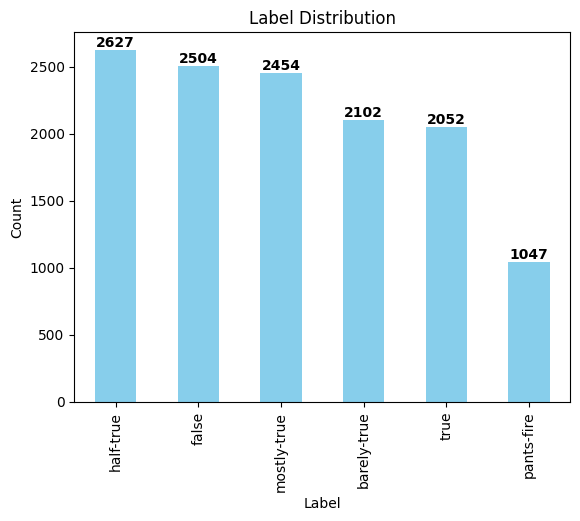

In [29]:
ax = df['label'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

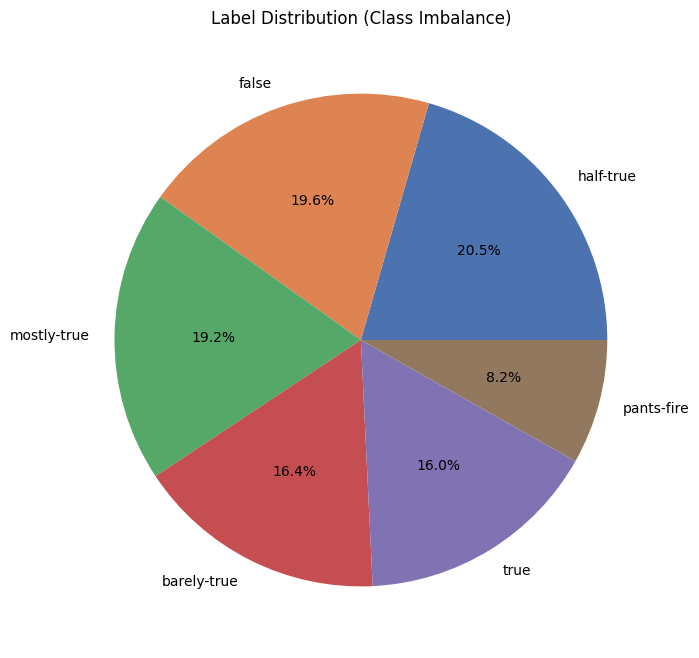

In [30]:
# Visualize label distribution (for classification)
plt.figure(figsize=(8, 8))
colors = sns.color_palette('deep')[0:6]
df['label'].value_counts().plot(kind='pie', colors = colors, autopct='%1.1f%%')

plt.title('Label Distribution (Class Imbalance)')
plt.ylabel('')
plt.show()

### The class distribution of the label look fairly balanced

## Check subject(s) distribution

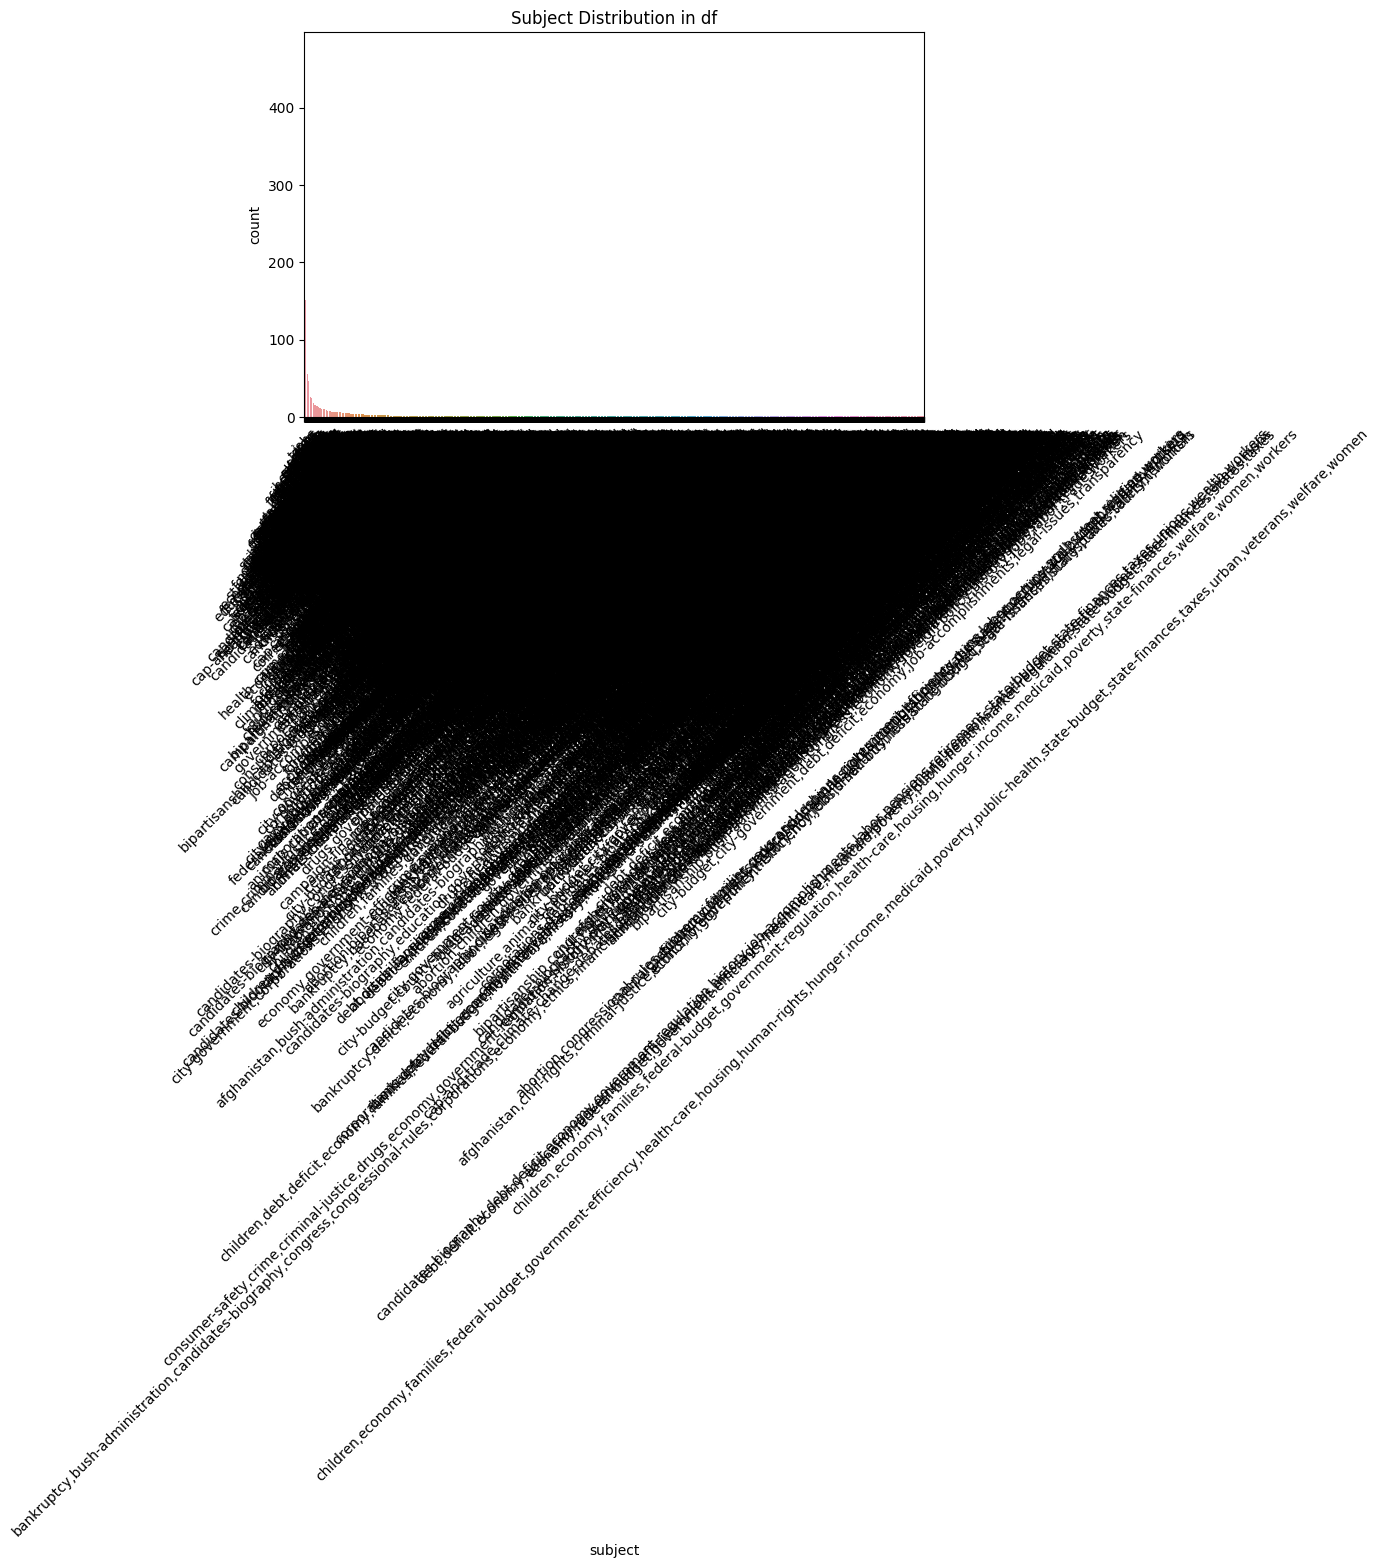

In [31]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="subject", order=df["subject"].value_counts().index)
plt.title("Subject Distribution in df")
plt.xticks(rotation=45)
plt.show()

### only show top 20 subjects

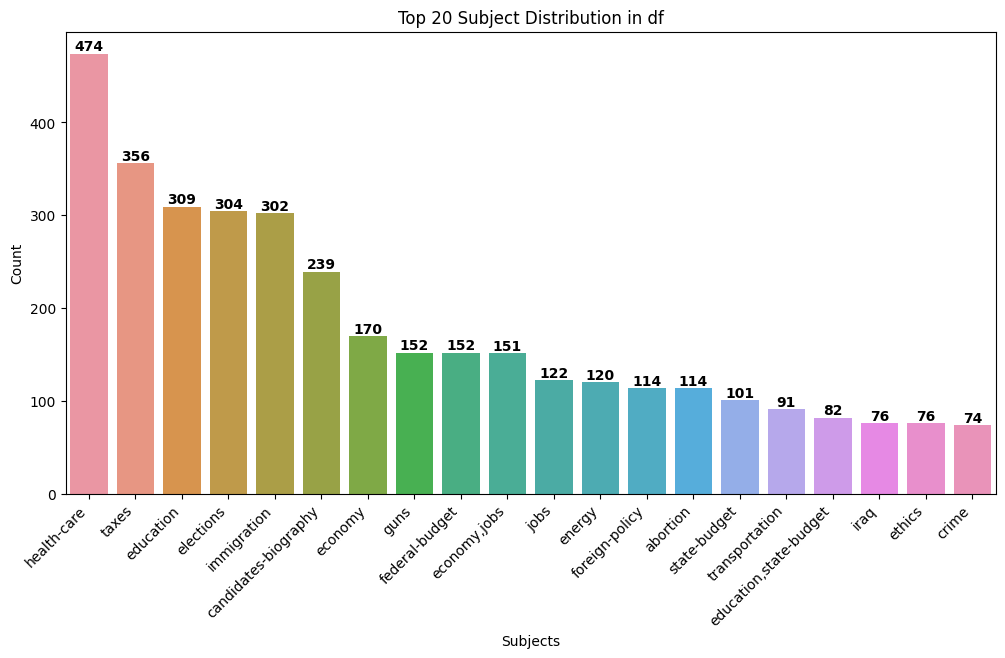

In [32]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="subject", order=df["subject"].value_counts().nlargest(20).index)

plt.title("Top 20 Subject Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Subjects")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

## Check Speaker Distribution

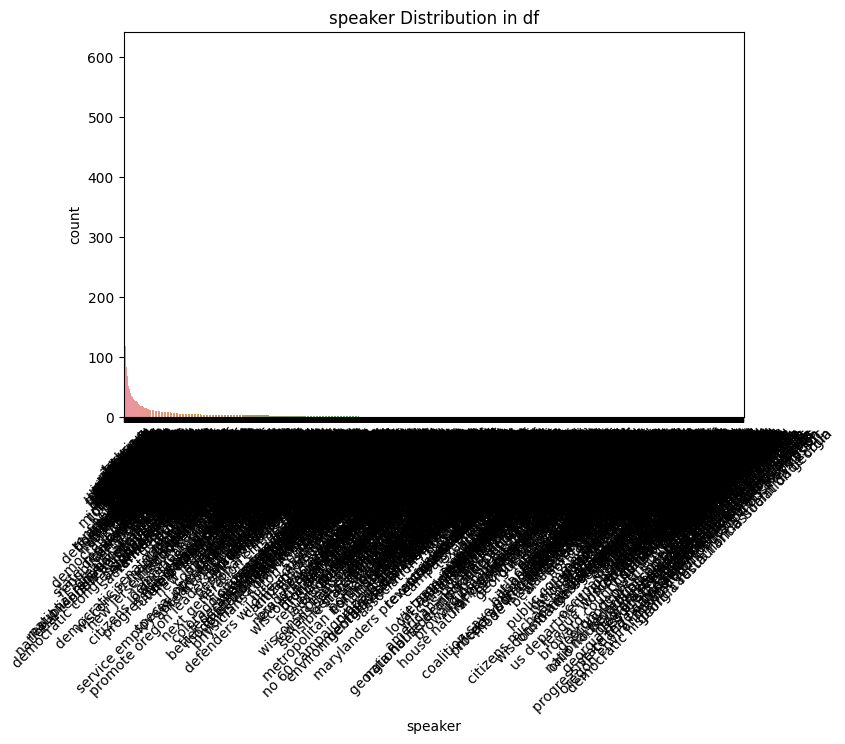

In [33]:
plt.figure(figsize=(8,5))

sns.countplot(data=df, x="speaker", order=df["speaker"].value_counts().index)
plt.title("speaker Distribution in df")
plt.xticks(rotation=45)

plt.show()

### Top 20 speakers

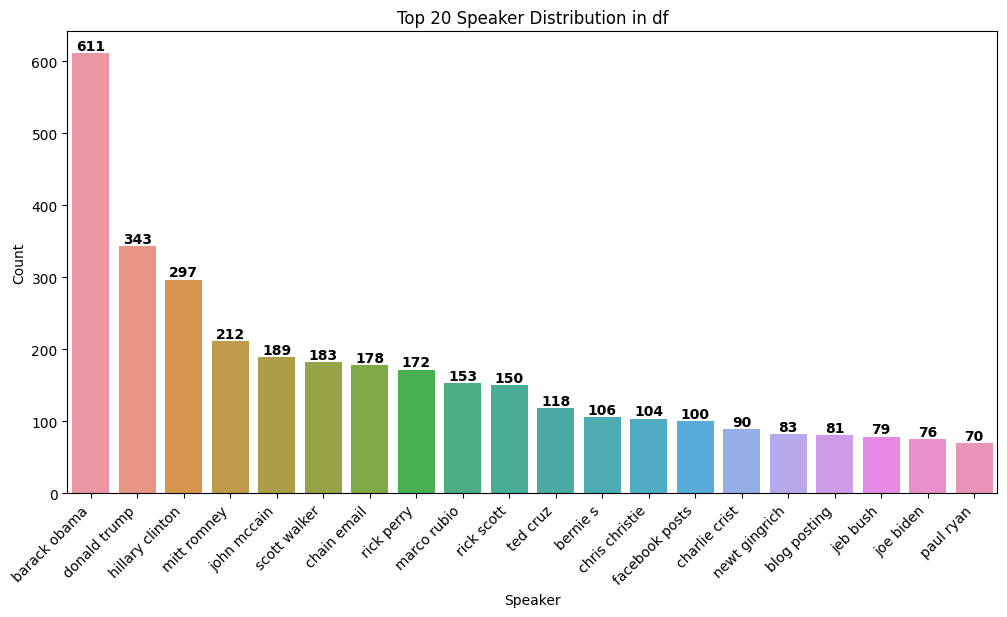

In [34]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="speaker", order=df["speaker"].value_counts().nlargest(20).index)

plt.title("Top 20 Speaker Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Speaker")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

### Visualise the distribution of labels for the statements made by each speaker



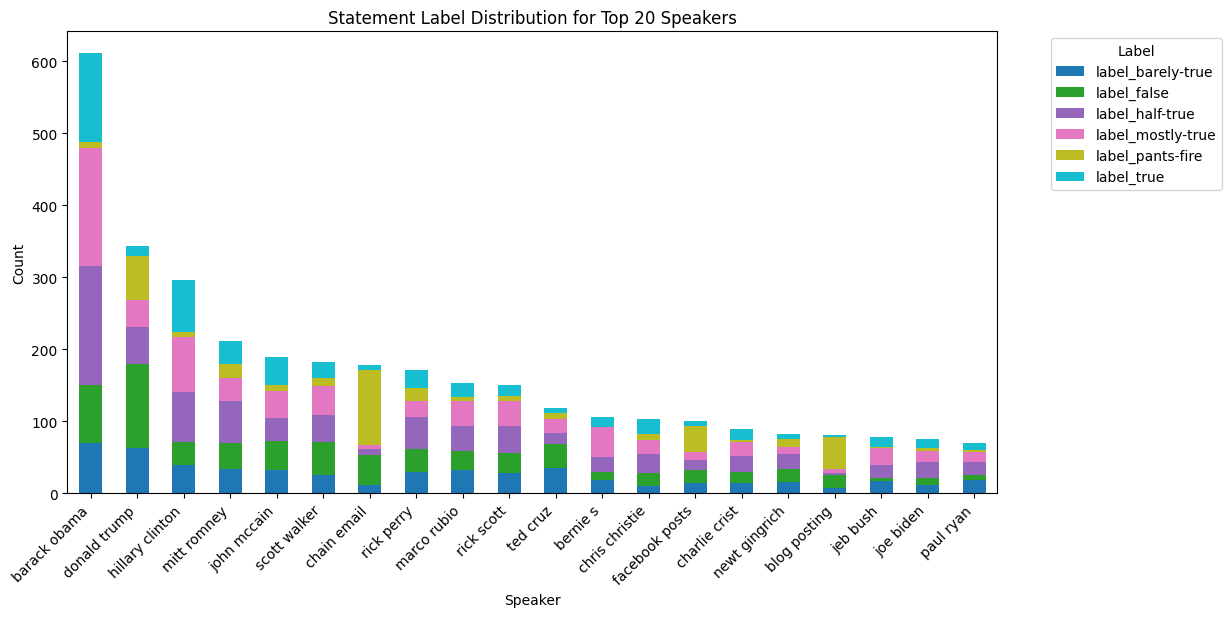

In [35]:
# Get the top 20 speakers by count
top_20_speakers = df["speaker"].value_counts().nlargest(20).index

# Filter the dataset to only include these speakers
df_top_speakers = df[df["speaker"].isin(top_20_speakers)]

# Aggregate the label counts for each speaker
label_columns = ["label_barely-true", "label_false", "label_half-true", "label_mostly-true", "label_pants-fire", "label_true"]
df_speaker_labels = df_top_speakers.groupby("speaker")[label_columns].sum()

# Order speakers by total statement count in descending order
df_speaker_labels["total_statements"] = df_speaker_labels.sum(axis=1)
df_speaker_labels = df_speaker_labels.sort_values(by="total_statements", ascending=False).drop(columns=["total_statements"])

# Plot stacked bar chart
df_speaker_labels.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")

plt.title("Statement Label Distribution for Top 20 Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

### Out of the top 20 speakers, we visualise the top 5 speakers with "True" statements and "False statements" (in terms of percentage)

In [36]:
# Compute percentages for "true" and "false" statements
df_speaker_labels["true_percentage"] = df_speaker_labels["label_true"] / df_speaker_labels.sum(axis=1) * 100
df_speaker_labels["false_percentage"] = df_speaker_labels["label_false"] / df_speaker_labels.sum(axis=1) * 100

# Get top 5 speakers with the highest percentage of "true" statements
top_5_true_speakers = df_speaker_labels.nlargest(5, "true_percentage")[["true_percentage", "label_true"]]

# Get top 5 speakers with the highest percentage of "false" statements
top_5_false_speakers = df_speaker_labels.nlargest(5, "false_percentage")[["false_percentage", "label_false"]]

# Function to retrieve additional speaker details
def get_speaker_details(df, speakers):
    return df[df["speaker"].isin(speakers)].groupby("speaker").first()[["speaker_job_title", "state_info", "party_affiliation"]]

# Merge with speaker details
top_5_true_speakers = top_5_true_speakers.merge(get_speaker_details(df, top_5_true_speakers.index), left_index=True, right_index=True)
top_5_false_speakers = top_5_false_speakers.merge(get_speaker_details(df, top_5_false_speakers.index), left_index=True, right_index=True)

# Display results
print("Top 5 Speakers with the Highest Percentage of 'True' Statements:")
top_5_true_speakers

Top 5 Speakers with the Highest Percentage of 'True' Statements:


true_percentage  label_true       speaker_job_title  \
speaker                                                                
hillary clinton        24.579125          73  presidential candidate   
chris christie         21.153846          22  governor of new jersey   
john mccain            20.634921          39            u s  senator   
barack obama           20.130933         123               president   
charlie crist          17.777778          16                 unknown   

                 state_info party_affiliation  
speaker                                        
hillary clinton    new york          democrat  
chris christie   new jersey        republican  
john mccain         arizona        republican  
barack obama       illinois          democrat  
charlie crist       florida          democrat

In [37]:
print("\nTop 5 Speakers with the Highest Percentage of 'False' Statements:")
top_5_false_speakers


Top 5 Speakers with the Highest Percentage of 'False' Statements:


false_percentage  label_false           speaker_job_title  \
speaker                                                                   
donald trump         33.709649          117             president elect   
ted cruz             27.434354           34                     senator   
scott walker         24.032524           47  milwaukee county executive   
chain email          23.708338           43                     unknown   
blog posting         22.431132           19                     unknown   

             state_info party_affiliation  
speaker                                    
donald trump   new york        republican  
ted cruz          texas        republican  
scott walker  wisconsin        republican  
chain email     unknown             other  
blog posting    unknown             other

## Check job title distribution

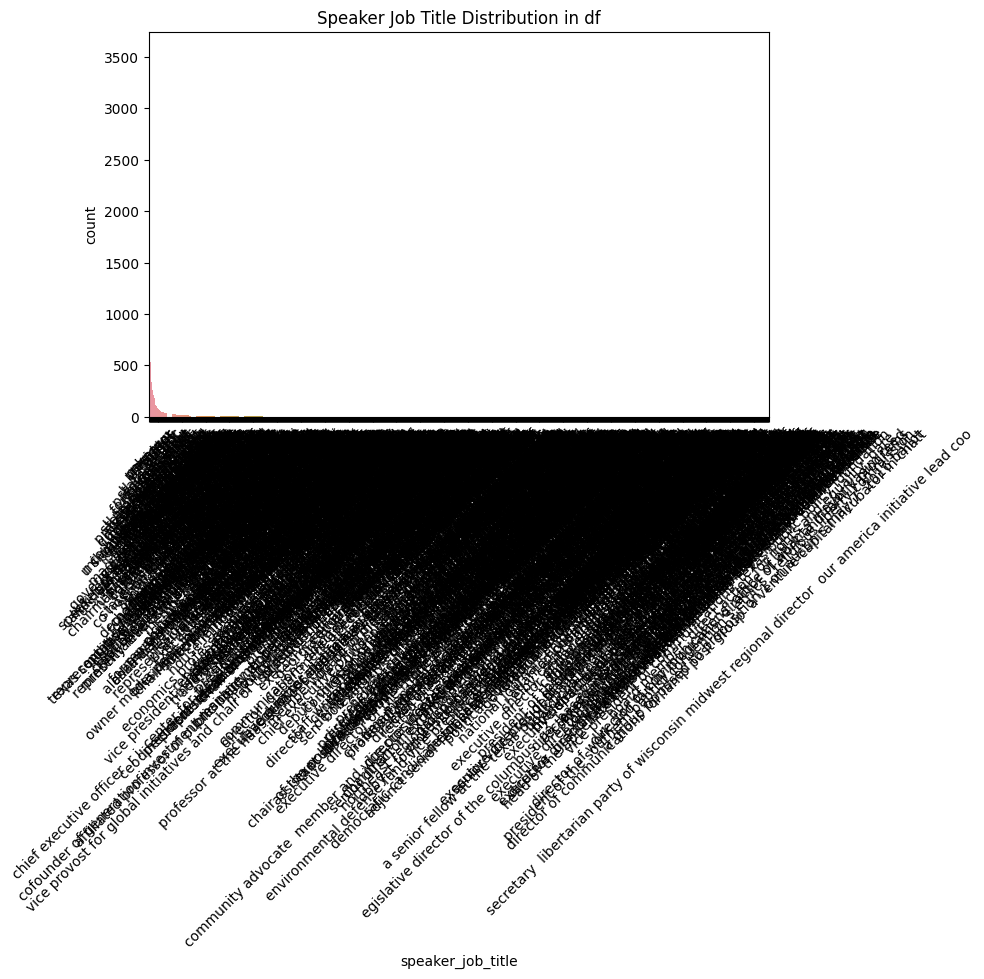

In [38]:
plt.figure(figsize=(8,5))

sns.countplot(data=df, x="speaker_job_title", order=df["speaker_job_title"].value_counts().index)
plt.title("Speaker Job Title Distribution in df")
plt.xticks(rotation=45)

plt.show()

### show top 20 job title distributions

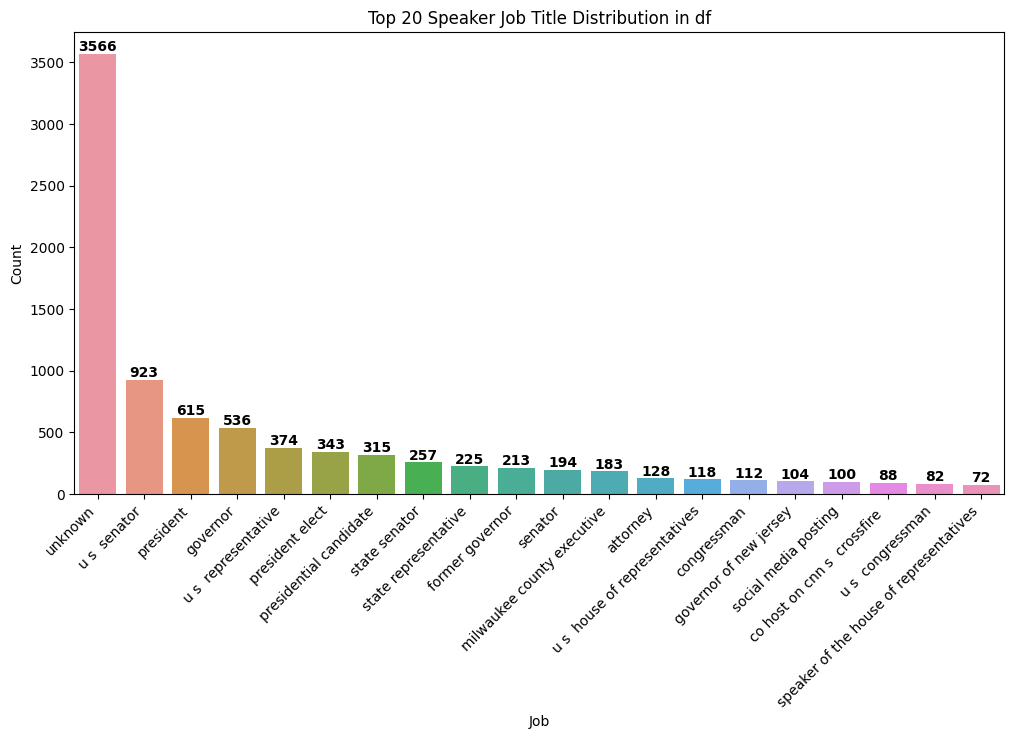

In [39]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="speaker_job_title", order=df["speaker_job_title"].value_counts().nlargest(20).index)

plt.title("Top 20 Speaker Job Title Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Job")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

## Check state info distribution

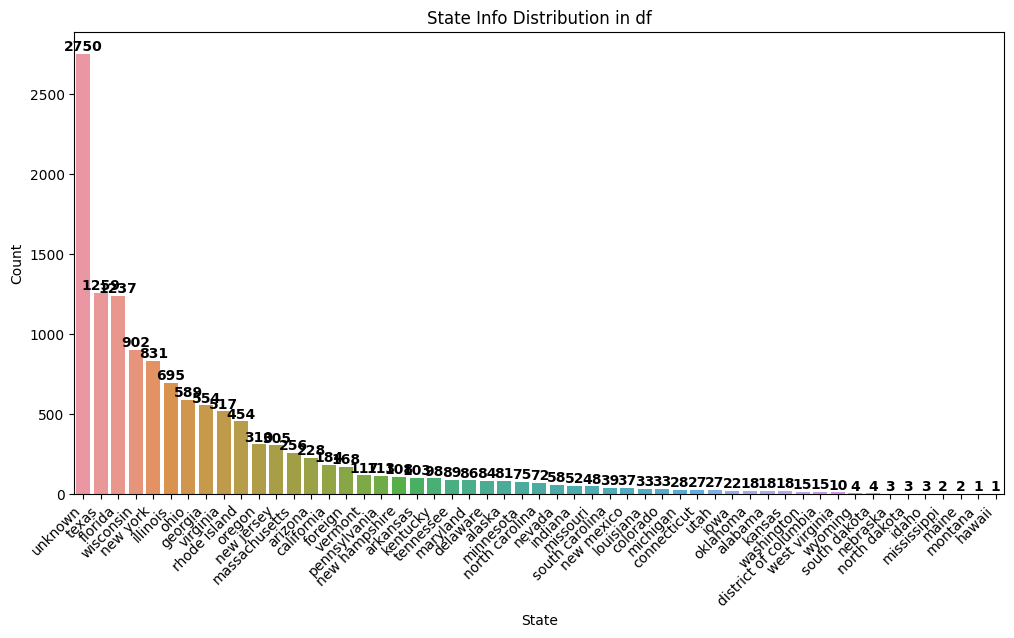

In [40]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x="state_info", order=df["state_info"].value_counts().index)

plt.title("State Info Distribution in df")
plt.xticks(rotation=45, ha="right")
plt.xlabel("State")
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

## Check party affliation distribution

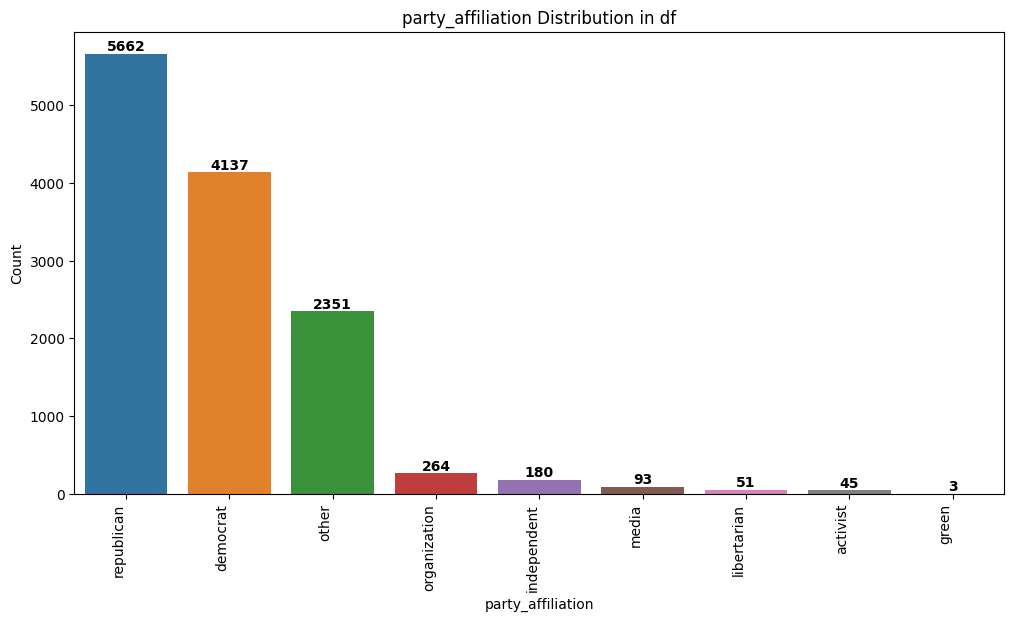

In [41]:
plt.figure(figsize=(12, 6))

# Order states in descending count order
order = df["party_affiliation"].value_counts().index

# Create count plot
ax = sns.countplot(data=df, x="party_affiliation", order=order)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', weight='bold')

# Adjust title and labels
plt.title("party_affiliation Distribution in df", fontsize=12)
plt.xticks(rotation=90, ha="right")
plt.ylabel("Count")

# Show the plot
plt.show()

## Check context distribution

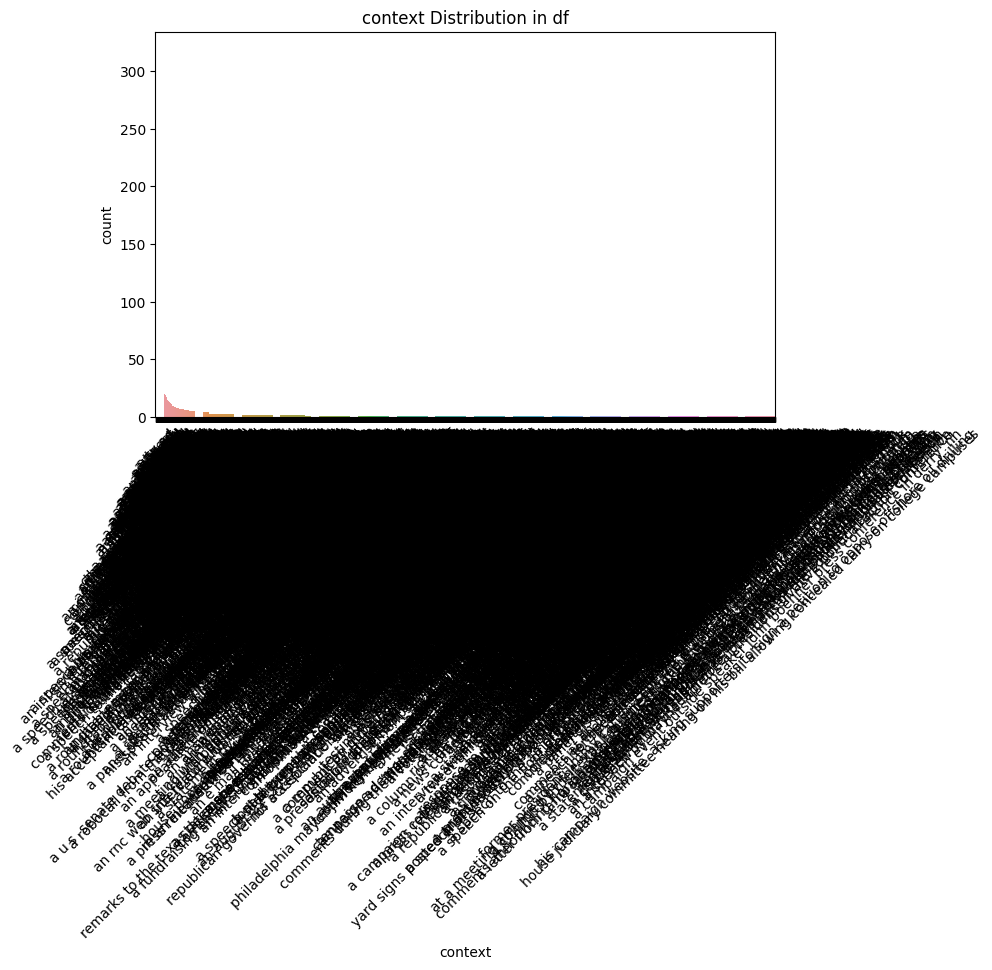

In [42]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="context", order=df["context"].value_counts().index)
plt.title("context Distribution in df")
plt.xticks(rotation=45)
plt.show()

## Word cloud for each label

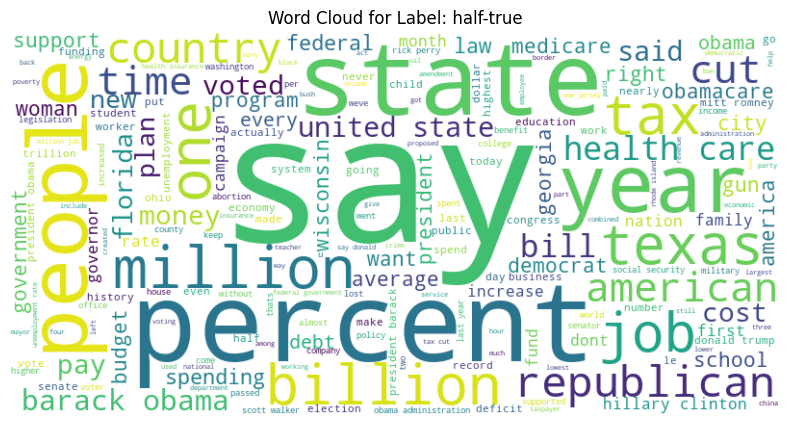

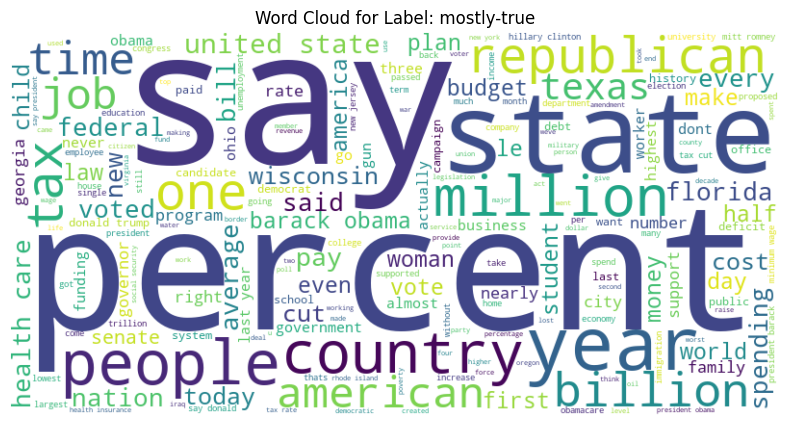

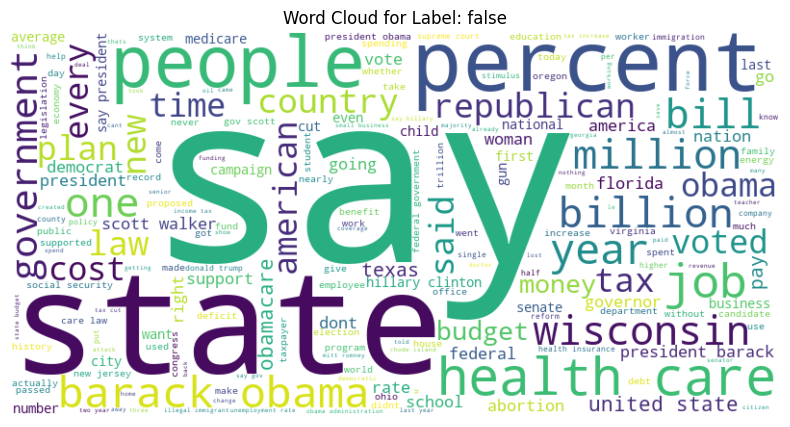

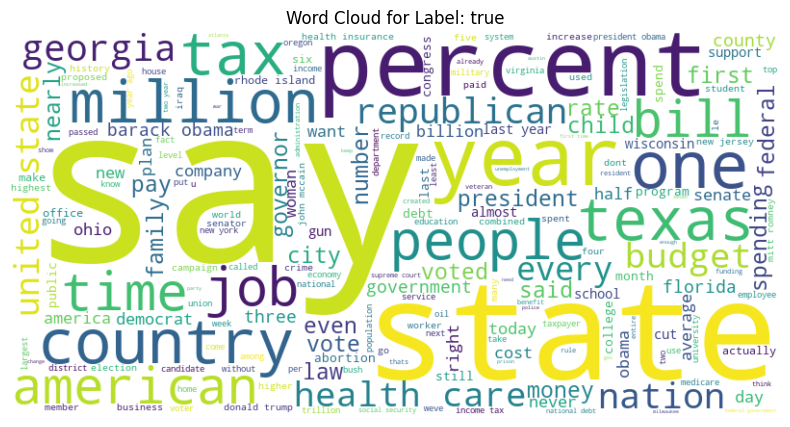

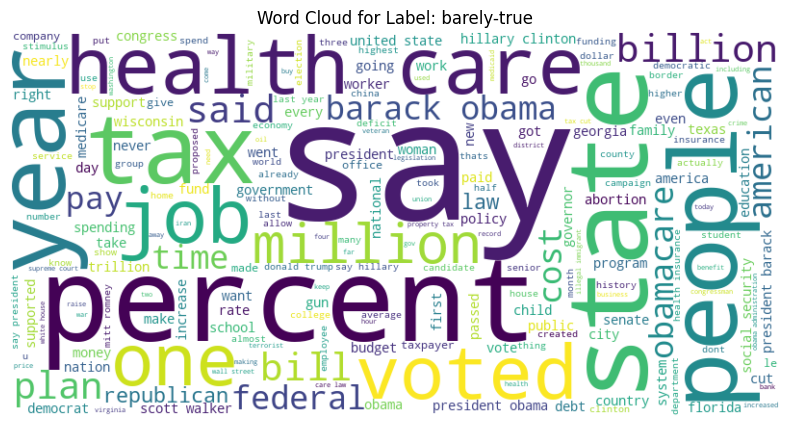

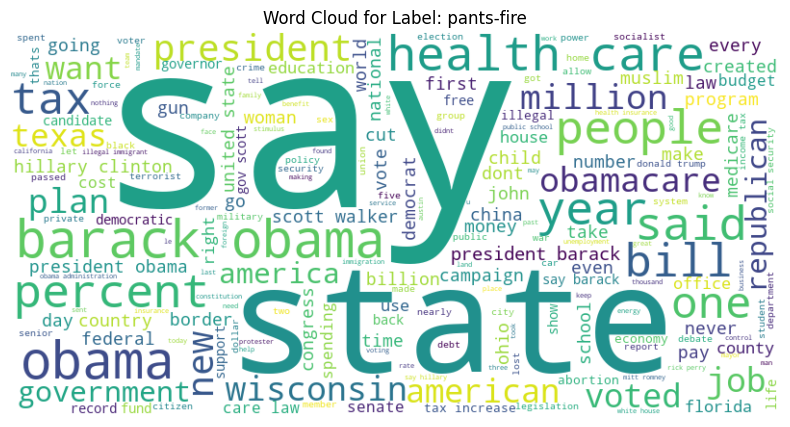

In [43]:
labels = df['label'].unique()

for label in labels:
    # Filter the data for the current label
    text = ' '.join(df[df['label'] == label]['statement'])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the WordCloud for the current label
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label: {label}')
    plt.show()

# Feature Engineering (No Need to Run, can just Open parquet File)
- 'statement': sentence embeddings
- 'subject': average of word embeddings
- 'speaker_job_title': named entity recognition
- 'context': word embeddings

## Checking updated values of features

In [44]:
categorical_columns = ['label', 'subject', 'speaker', 'speaker_job_title', 'state_info', 'party_affiliation', 'context']
categorical_uniques_sum = {col: df[col].nunique() for col in categorical_columns}
categorical_uniques_sum

{'label': 6,
 'subject': 4534,
 'speaker': 3308,
 'speaker_job_title': 1266,
 'state_info': 53,
 'party_affiliation': 9,
 'context': 4944}

In [45]:
categorical_uniques = {col: df[col].unique() for col in categorical_columns}
categorical_uniques

{'label': array(['half-true', 'mostly-true', 'false', 'true', 'barely-true',
        'pants-fire'], dtype=object),
 'subject': array(['energy,history,job-accomplishments', 'foreign-policy',
        'health-care', ..., 'animals,candidates-biography',
        'bipartisanship,congress,foreign-policy,history',
        'environment,government-efficiency'], dtype=object),
 'speaker': array(['scott surovell', 'barack obama', 'blog posting', ...,
        'hugh fitzsimons', 'menendez facts', 'mackubin thomas owens'],
       dtype=object),
 'speaker_job_title': array(['state delegate', 'president', 'unknown', ...,
        'u s  supreme court justice', 'rancher',
        'senior fellow  foreign policy research institute'], dtype=object),
 'state_info': array(['virginia', 'illinois', 'unknown', 'florida', 'wisconsin', 'texas',
        'new jersey', 'vermont', 'massachusetts', 'maryland', 'foreign',
        'oregon', 'new york', 'california', 'missouri', 'rhode island',
        'west virginia', 'ar

## 'statement' Feature Engineering
- to ensure that 'statement' is prepared to be fed into neural network models, we use sentence embeddings to get dense representations
- we use the 'all-MiniLM-L6-v2' as it is general purpose and provides a good balance between performance and speed

In [46]:
# load sentence embeddints for 'statement'
print("Loading SBERT model...")
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Loading SBERT model...


In [47]:
# apply model to the 'statement' column
def get_sentence_embedding(text):
    return sbert_model.encode(text)

# save embeddings to a new column
df['statement_embedding'] = df['statement'].apply(get_sentence_embedding)

In [48]:
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown             other   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  ...  mostly_true_counts  \
0                 0.0           0.0  ...                 1.0   
1                70.0          71.0  ...               163.0   
2                 7.0          19.0  ...                 5.0   
3                15.0           9.0  ...                19.0   
4                 0.0           3.0  ...                 5.0   

   pants_on_fire_counts                    context label_barely-true  \
0                   0.0            a floor speech                  0   
1                   9.0                     denver                 0   
2                  44.0             a news release                 0   
3                   2.0        an interview on cnn                 0   
4                   1.0  a an online opinion piece                 0   

   label_false  label_half-true  label_mostly-true  label_pants-fire  \
0            0                1                  0                 0   
1            0                0                  1                 0   
2            1                0                  0                 0   
3            0                1                  0                 0   
4            0                0                  0                 0   

   label_true                                statement_embedding  
0           0  [0.0063646655, -0.008944523, 0.059672374, -0.0...  
1           0  [0.013851577, 0.0041128453, -0.0393607, -0.014...  
2           0  [-0.04322322, 0.07710014, 0.00059251906, 0.049...  
3           0  [-0.030549154, -0.018898467, 0.07523326, -0.02...  
4           1  [0.033326626, -0.05953103, -0.010501049, 0.012...  

[5 rows x 21 columns]

## 'subject' Feature Engineering
- use sentence embeddings also as there may be several words in a subject (FastText is unable to)
- sentence transformer will be able to take into context and also account for hyphenated-words (GloVe is unable to)

In [49]:
# save embeddings to a new column
df['subject_embedding'] = df['subject'].apply(get_sentence_embedding)

In [50]:
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown             other   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  ...  pants_on_fire_counts  \
0                 0.0           0.0  ...                   0.0   
1                70.0          71.0  ...                   9.0   
2                 7.0          19.0  ...                  44.0   
3                15.0           9.0  ...                   2.0   
4                 0.0           3.0  ...                   1.0   

                     context  label_barely-true label_false  label_half-true  \
0            a floor speech                   0           0                1   
1                     denver                  0           0                0   
2             a news release                  0           1                0   
3        an interview on cnn                  0           0                1   
4  a an online opinion piece                  0           0                0   

   label_mostly-true  label_pants-fire  label_true  \
0                  0                 0           0   
1                  1                 0           0   
2                  0                 0           0   
3                  0                 0           0   
4                  0                 0           1   

                                 statement_embedding  \
0  [0.0063646655, -0.008944523, 0.059672374, -0.0...   
1  [0.013851577, 0.0041128453, -0.0393607, -0.014...   
2  [-0.04322322, 0.07710014, 0.00059251906, 0.049...   
3  [-0.030549154, -0.018898467, 0.07523326, -0.02...   
4  [0.033326626, -0.05953103, -0.010501049, 0.012...   

                                   subject_embedding  
0  [-0.05959159, 0.10549757, 0.008828341, 0.07442...  
1  [0.002265804, 0.01357501, -0.012980664, -0.050...  
2  [-0.038733505, 0.080663756, 0.03875507, 0.0368...  
3  [-0.026338141, 0.039439037, -0.018505596, 0.06...  
4  [0.030874366, 0.099936485, -0.020643018, 0.076...  

[5 rows x 22 columns]

## 'state_info' Feature Engineering
- use label encoder as state_info is categorical and there are only 53 unique values

In [51]:
label_encoder = LabelEncoder()

# encode 'state_info' column and assign it to a new column
df['state_info_encoded'] = label_encoder.fit_transform(df['state_info'])

In [52]:
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown             other   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  ...                    context  \
0                 0.0           0.0  ...            a floor speech    
1                70.0          71.0  ...                     denver   
2                 7.0          19.0  ...             a news release   
3                15.0           9.0  ...        an interview on cnn   
4                 0.0           3.0  ...  a an online opinion piece   

   label_barely-true  label_false label_half-true  label_mostly-true  \
0                  0            0               1                  0   
1                  0            0               0                  1   
2                  0            1               0                  0   
3                  0            0               1                  0   
4                  0            0               0                  0   

   label_pants-fire  label_true  \
0                 0           0   
1                 0           0   
2                 0           0   
3                 0           0   
4                 0           1   

                                 statement_embedding  \
0  [0.0063646655, -0.008944523, 0.059672374, -0.0...   
1  [0.013851577, 0.0041128453, -0.0393607, -0.014...   
2  [-0.04322322, 0.07710014, 0.00059251906, 0.049...   
3  [-0.030549154, -0.018898467, 0.07523326, -0.02...   
4  [0.033326626, -0.05953103, -0.010501049, 0.012...   

                                   subject_embedding  state_info_encoded  
0  [-0.05959159, 0.10549757, 0.008828341, 0.07442...                  48  
1  [0.002265804, 0.01357501, -0.012980664, -0.050...                  14  
2  [-0.038733505, 0.080663756, 0.03875507, 0.0368...                  45  
3  [-0.026338141, 0.039439037, -0.018505596, 0.06...                   9  
4  [0.030874366, 0.099936485, -0.020643018, 0.076...                  51  

[5 rows x 23 columns]

## 'party_affiliation' Feature Engineering
- use label encoder as party_affiliaiton is categorical and there are only 9 unique values

In [53]:
# encode 'party_affiliation' column and assign it to a new column
df['party_affiliation_encoded'] = label_encoder.fit_transform(df['party_affiliation'])

In [54]:
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown             other   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  ...  label_barely-true  label_false  \
0                 0.0           0.0  ...                  0            0   
1                70.0          71.0  ...                  0            0   
2                 7.0          19.0  ...                  0            1   
3                15.0           9.0  ...                  0            0   
4                 0.0           3.0  ...                  0            0   

   label_half-true label_mostly-true  label_pants-fire  label_true  \
0                1                 0                 0           0   
1                0                 1                 0           0   
2                0                 0                 0           0   
3                1                 0                 0           0   
4                0                 0                 0           1   

                                 statement_embedding  \
0  [0.0063646655, -0.008944523, 0.059672374, -0.0...   
1  [0.013851577, 0.0041128453, -0.0393607, -0.014...   
2  [-0.04322322, 0.07710014, 0.00059251906, 0.049...   
3  [-0.030549154, -0.018898467, 0.07523326, -0.02...   
4  [0.033326626, -0.05953103, -0.010501049, 0.012...   

                                   subject_embedding  state_info_encoded  \
0  [-0.05959159, 0.10549757, 0.008828341, 0.07442...                  48   
1  [0.002265804, 0.01357501, -0.012980664, -0.050...                  14   
2  [-0.038733505, 0.080663756, 0.03875507, 0.0368...                  45   
3  [-0.026338141, 0.039439037, -0.018505596, 0.06...                   9   
4  [0.030874366, 0.099936485, -0.020643018, 0.076...                  51   

   party_affiliation_encoded  
0                          1  
1                          1  
2                          7  
3                          1  
4                          8  

[5 rows x 24 columns]

## 'speaker_job_title' Feature Engineering
- using the sentence transformer to provide embeddings since some of the column values consist of multiple words

In [55]:
df['speaker_job_title_embedding'] = df['speaker_job_title'].apply(get_sentence_embedding)

In [56]:
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown             other   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  ...  label_false  label_half-true  \
0                 0.0           0.0  ...            0                1   
1                70.0          71.0  ...            0                0   
2                 7.0          19.0  ...            1                0   
3                15.0           9.0  ...            0                1   
4                 0.0           3.0  ...            0                0   

   label_mostly-true label_pants-fire  label_true  \
0                  0                0           0   
1                  1                0           0   
2                  0                0           0   
3                  0                0           0   
4                  0                0           1   

                                 statement_embedding  \
0  [0.0063646655, -0.008944523, 0.059672374, -0.0...   
1  [0.013851577, 0.0041128453, -0.0393607, -0.014...   
2  [-0.04322322, 0.07710014, 0.00059251906, 0.049...   
3  [-0.030549154, -0.018898467, 0.07523326, -0.02...   
4  [0.033326626, -0.05953103, -0.010501049, 0.012...   

                                   subject_embedding  state_info_encoded  \
0  [-0.05959159, 0.10549757, 0.008828341, 0.07442...                  48   
1  [0.002265804, 0.01357501, -0.012980664, -0.050...                  14   
2  [-0.038733505, 0.080663756, 0.03875507, 0.0368...                  45   
3  [-0.026338141, 0.039439037, -0.018505596, 0.06...                   9   
4  [0.030874366, 0.099936485, -0.020643018, 0.076...                  51   

   party_affiliation_encoded  \
0                          1   
1                          1   
2                          7   
3                          1   
4                          8   

                         speaker_job_title_embedding  
0  [-0.007931831, 0.027872475, 0.014903477, 0.023...  
1  [-0.05484859, 0.07214372, 0.021329945, -0.0113...  
2  [-0.043102607, 0.06563704, -0.06752261, 0.0749...  
3  [-0.043102607, 0.06563704, -0.06752261, 0.0749...  
4  [-0.06843914, -0.008476282, -0.022418255, -0.0...  

[5 rows x 25 columns]

## 'context' Feature Engineering
- context is a string of multiple words, so we use the sentence transformer to get the appropriate embeddings

In [57]:
df['context_embedding'] = df['context'].apply(get_sentence_embedding)

In [58]:
df.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown             other   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  ...  label_half-true  label_mostly-true  \
0                 0.0           0.0  ...                1                  0   
1                70.0          71.0  ...                0                  1   
2                 7.0          19.0  ...                0                  0   
3                15.0           9.0  ...                1                  0   
4                 0.0           3.0  ...                0                  0   

   label_pants-fire label_true  \
0                 0          0   
1                 0          0   
2                 0          0   
3                 0          0   
4                 0          1   

                                 statement_embedding  \
0  [0.0063646655, -0.008944523, 0.059672374, -0.0...   
1  [0.013851577, 0.0041128453, -0.0393607, -0.014...   
2  [-0.04322322, 0.07710014, 0.00059251906, 0.049...   
3  [-0.030549154, -0.018898467, 0.07523326, -0.02...   
4  [0.033326626, -0.05953103, -0.010501049, 0.012...   

                                   subject_embedding  state_info_encoded  \
0  [-0.05959159, 0.10549757, 0.008828341, 0.07442...                  48   
1  [0.002265804, 0.01357501, -0.012980664, -0.050...                  14   
2  [-0.038733505, 0.080663756, 0.03875507, 0.0368...                  45   
3  [-0.026338141, 0.039439037, -0.018505596, 0.06...                   9   
4  [0.030874366, 0.099936485, -0.020643018, 0.076...                  51   

   party_affiliation_encoded  \
0                          1   
1                          1   
2                          7   
3                          1   
4                          8   

                         speaker_job_title_embedding  \
0  [-0.007931831, 0.027872475, 0.014903477, 0.023...   
1  [-0.05484859, 0.07214372, 0.021329945, -0.0113...   
2  [-0.043102607, 0.06563704, -0.06752261, 0.0749...   
3  [-0.043102607, 0.06563704, -0.06752261, 0.0749...   
4  [-0.06843914, -0.008476282, -0.022418255, -0.0...   

                                   context_embedding  
0  [-0.009640211, 0.033441495, -0.024816759, -0.0...  
1  [0.1250994, -0.043436233, -0.0020739704, 0.016...  
2  [-0.011820267, 0.055349898, 0.016241811, 0.079...  
3  [-0.083262496, 0.05560122, 0.037349723, 0.0854...  
4  [-0.07548957, 0.029602868, -0.051304653, -0.03...  

[5 rows x 26 columns]

## Saving the embeddings as a parquet file

In [60]:
for col in ["statement_embedding", "subject_embedding", "speaker_job_title_embedding", "context_embedding"]:
    df[col] = df[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df.to_parquet("df_feature_engineering.parquet", index=False)

# Open feature engineered dataframe (No need to process text again)

In [61]:
df_feature_engineered = pd.read_parquet('df_feature_engineering.parquet')
df_feature_engineered.head()

id        label                                          statement  \
0  10540.json    half-true  decline coal start started natural gas took st...   
1    324.json  mostly-true  hillary clinton agrees john mccain voting give...   
2   1123.json        false  health care reform legislation likely mandate ...   
3   9028.json    half-true               economic turnaround started end term   
4  12465.json         true  chicago bear starting quarterback last year to...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott surovell   
1                      foreign-policy    barack obama   
2                         health-care    blog posting   
3                        economy,jobs   charlie crist   
4                           education       robin vos   

            speaker_job_title state_info party_affiliation  \
0              state delegate   virginia          democrat   
1                   president   illinois          democrat   
2                     unknown    unknown             other   
3                     unknown    florida          democrat   
4  wisconsin assembly speaker  wisconsin        republican   

   barely_true_counts  false_counts  ...  label_half-true  label_mostly-true  \
0                 0.0           0.0  ...                1                  0   
1                70.0          71.0  ...                0                  1   
2                 7.0          19.0  ...                0                  0   
3                15.0           9.0  ...                1                  0   
4                 0.0           3.0  ...                0                  0   

   label_pants-fire label_true  \
0                 0          0   
1                 0          0   
2                 0          0   
3                 0          0   
4                 0          1   

                                 statement_embedding  \
0  [0.00636466545984149, -0.008944522589445114, 0...   
1  [0.013851577416062355, 0.004112845286726952, -...   
2  [-0.043223220854997635, 0.07710014283657074, 0...   
3  [-0.030549153685569763, -0.01889846660196781, ...   
4  [0.03332662582397461, -0.05953102931380272, -0...   

                                   subject_embedding  state_info_encoded  \
0  [-0.059591591358184814, 0.1054975688457489, 0....                  48   
1  [0.0022658039815723896, 0.013575010001659393, ...                  14   
2  [-0.038733504712581635, 0.0806637555360794, 0....                  45   
3  [-0.026338141411542892, 0.039439037442207336, ...                   9   
4  [0.03087436594069004, 0.09993648529052734, -0....                  51   

   party_affiliation_encoded  \
0                          1   
1                          1   
2                          7   
3                          1   
4                          8   

                         speaker_job_title_embedding  \
0  [-0.007931831292808056, 0.027872474864125252, ...   
1  [-0.05484858900308609, 0.07214371860027313, 0....   
2  [-0.043102607131004333, 0.06563703715801239, -...   
3  [-0.043102607131004333, 0.06563703715801239, -...   
4  [-0.06843914091587067, -0.00847628153860569, -...   

                                   context_embedding  
0  [-0.00964021123945713, 0.03344149515032768, -0...  
1  [0.12509940564632416, -0.04343623295426369, -0...  
2  [-0.011820266954600811, 0.05534989759325981, 0...  
3  [-0.08326249569654465, 0.055601220577955246, 0...  
4  [-0.0754895731806755, 0.029602868482470512, -0...  

[5 rows x 26 columns]

# Splitting the Dataset
1. we split the data into train and test sets (80:20)
2. we split the train data into train and validation sets (80:20)

In [63]:
# count total number of rows
total_rows = df_feature_engineered.shape[0]
print(f"total number of rows: {total_rows}")

# get column names
column_names = df_feature_engineered.columns
print(f"column names: {column_names}")

total number of rows: 12786
column names: Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context', 'label_barely-true', 'label_false', 'label_half-true',
       'label_mostly-true', 'label_pants-fire', 'label_true',
       'statement_embedding', 'subject_embedding', 'state_info_encoded',
       'party_affiliation_encoded', 'speaker_job_title_embedding',
       'context_embedding'],
      dtype='object')


In [70]:
x = df[['statement_embedding', 'subject_embedding', 'speaker_job_title_embedding', 'state_info_encoded', 'party_affiliation_encoded', 'context_embedding']]
y = df[['label_barely-true', 'label_false', 'label_half-true', 'label_mostly-true', 'label_pants-fire', 'label_true']]

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# final sizes of the sets
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")


Training set size: 8182
Validation set size: 2046
Test set size: 2558


In [72]:
x_train.head()


statement_embedding  \
2539   [0.0008672866970300674, -0.03910582512617111, ...   
323    [0.008821277879178524, -0.06109123304486275, -...   
9335   [-0.13163694739341736, 0.06163007393479347, 0....   
11284  [0.06950153410434723, -0.06952039897441864, -0...   
11273  [-0.03437541052699089, 0.05887250602245331, 0....   

                                       subject_embedding  \
2539   [-0.016253430396318436, 0.01504842471331358, 0...   
323    [0.04645084962248802, -0.028025217354297638, 0...   
9335   [0.0395297072827816, 0.00016752432566136122, -...   
11284  [0.08998893946409225, -0.059886634349823, -0.0...   
11273  [-0.020419949665665627, 0.10838941484689713, -...   

                             speaker_job_title_embedding  state_info_encoded  \
2539   [-0.01612822152674198, 0.01917792111635208, -0...                  51   
323    [-0.007758185267448425, -0.016908753663301468,...                  21   
9335   [-0.03341105952858925, 0.0166589617729187, -0....                  11   
11284  [-0.043102607131004333, 0.06563703715801239, -...                  45   
11273  [-0.02569442242383957, -0.005478965118527412, ...                  11   

       party_affiliation_encoded  \
2539                           8   
323                            1   
9335                           8   
11284                          7   
11273                          1   

                                       context_embedding  
2539   [-0.02246275544166565, 0.09968536347150803, 0....  
323    [-0.047936659306287766, -0.011349179781973362,...  
9335   [-0.08001700788736343, 0.11824852973222733, 0....  
11284  [-0.026120789349079132, -0.016503730788826942,...  
11273  [0.004389405716210604, 0.05201825499534607, -0...

In [73]:
y_train.head()

label_barely-true  label_false  label_half-true  label_mostly-true  \
2539                   0            0                1                  0   
323                    0            1                0                  0   
9335                   0            0                1                  0   
11284                  0            0                0                  1   
11273                  0            0                0                  0   

       label_pants-fire  label_true  
2539                  0           0  
323                   0           0  
9335                  0           0  
11284                 0           0  
11273                 0           1